# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [59]:
# code here
import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [60]:

import time
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10


# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define number of subprocesses to use for data loading
num_workers = 2

# Define how many samples per batch to load
batch_size = 16

# Download and load CIFAR10 dataset
train_data = CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='data', train=False, download=True, transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))

# Define samplers for obtaining training batches
train_sampler = SubsetRandomSampler(indices)

# Prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
torch.Size([16])


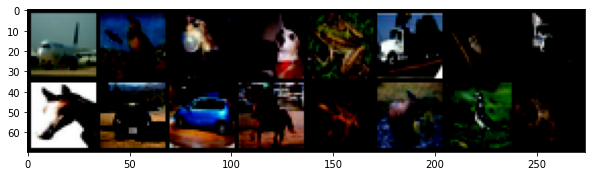

In [61]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [62]:

import torch
import torch.nn as nn


class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=16 * 3 * 32 * 32, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=16 * 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 24, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=15),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 1, 1)),
            nn.ConvTranspose2d(32, 24, kernel_size=15),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=15 * 15 * 24, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=15 * 15 * 24),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(24, 15, 15)),
            nn.ConvTranspose2d(in_channels=24, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [63]:


def create_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MLPAutoEncoder().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-3, 
                                 weight_decay=1e-5)
    return model, criterion, optimizer, device

In [64]:
model, criterion, optimizer, device = create_model()


In [65]:

NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    for images, _ in train_loader:
        images = images.reshape(-1, 16*3*32*32).to(device) 
        reconstructions = model(images)
        loss = criterion(reconstructions, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    epoch_loss = loss.item()
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))


Epoch: 1, Time: 28.3625, Loss: 0.3444
Epoch: 2, Time: 27.6044, Loss: 0.2504
Epoch: 3, Time: 29.3431, Loss: 0.2830
Epoch: 4, Time: 27.7861, Loss: 0.2516
Epoch: 5, Time: 28.3940, Loss: 0.2768


Original images shape: torch.Size([16, 3, 32, 32])


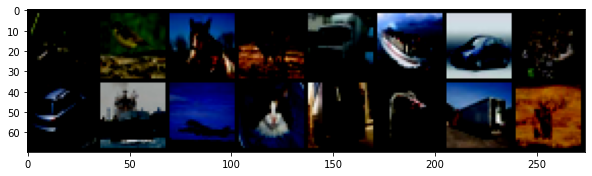

Reconstructed images shape: torch.Size([16, 3, 32, 32])


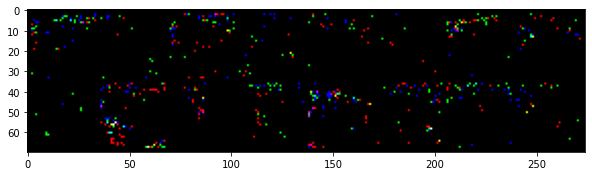

In [66]:


imgs = outputs[4][1].detach().cpu()
recon = outputs[4][2].detach().cpu()

# Display the original images
item = imgs.reshape(16, 3, 32, 32)
print(f"Original images shape: {item.shape}")
imshow(torchvision.utils.make_grid(item))

# Display the reconstructed images
item = recon.reshape(16, 3, 32, 32)
print(f"Reconstructed images shape: {item.shape}")
imshow(torchvision.utils.make_grid(item))


In [67]:

model2 = CNNAutoEncoder().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)



In [68]:

NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model2(images)
        loss = criterion(reconstructions, images)
        
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))



Epoch: 1, Time: 28.2063, Loss: 0.1869
Epoch: 2, Time: 28.1870, Loss: 0.1631
Epoch: 3, Time: 28.9578, Loss: 0.1625
Epoch: 4, Time: 28.1333, Loss: 0.1622
Epoch: 5, Time: 28.1731, Loss: 0.1620


Shape of item: torch.Size([16, 3, 32, 32])


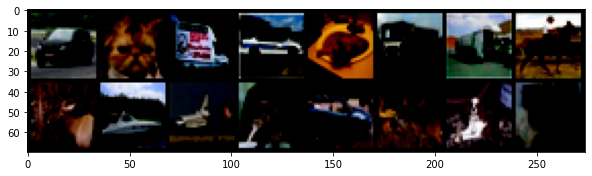

Shape of item: torch.Size([16, 3, 32, 32])


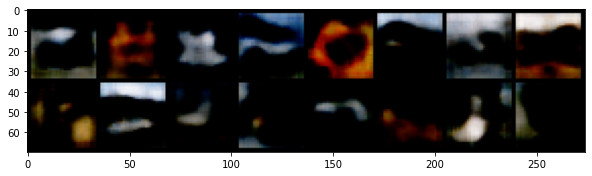

In [69]:


with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))


In [70]:


model3 = ComboAutoEncoder().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-5)


In [71]:


NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model3(images)
        loss = criterion(reconstructions, images)
        
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))


Epoch: 1, Time: 32.8116, Loss: 0.1934
Epoch: 2, Time: 31.8212, Loss: 0.1715
Epoch: 3, Time: 32.4804, Loss: 0.1680
Epoch: 4, Time: 31.9880, Loss: 0.1661
Epoch: 5, Time: 32.8800, Loss: 0.1649


Shape of item: torch.Size([16, 3, 32, 32])


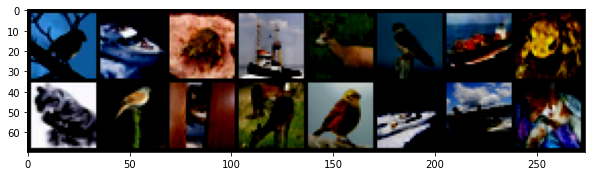

Shape of item: torch.Size([16, 3, 32, 32])


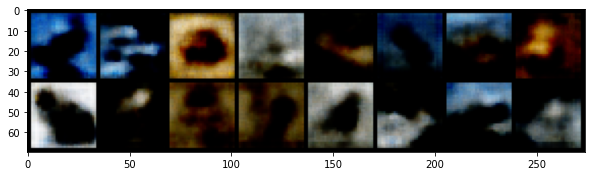

In [72]:

with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [73]:
# code here
from torchsummary import summary
print(summary(model2, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 24, 15, 15]           1,560
              ReLU-4           [-1, 24, 15, 15]               0
            Conv2d-5             [-1, 32, 1, 1]         172,832
           Flatten-6                   [-1, 32]               0
         Unflatten-7             [-1, 32, 1, 1]               0
   ConvTranspose2d-8           [-1, 24, 15, 15]         172,824
              ReLU-9           [-1, 24, 15, 15]               0
  ConvTranspose2d-10           [-1, 16, 30, 30]           1,552
             ReLU-11           [-1, 16, 30, 30]               0
  ConvTranspose2d-12            [-1, 3, 32, 32]             435
          Sigmoid-13            [-1, 3, 32, 32]               0
Total params: 349,651
Trainable params:

In [74]:
print(summary(model2, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 24, 15, 15]           1,560
              ReLU-4           [-1, 24, 15, 15]               0
            Conv2d-5             [-1, 32, 1, 1]         172,832
           Flatten-6                   [-1, 32]               0
         Unflatten-7             [-1, 32, 1, 1]               0
   ConvTranspose2d-8           [-1, 24, 15, 15]         172,824
              ReLU-9           [-1, 24, 15, 15]               0
  ConvTranspose2d-10           [-1, 16, 30, 30]           1,552
             ReLU-11           [-1, 16, 30, 30]               0
  ConvTranspose2d-12            [-1, 3, 32, 32]             435
          Sigmoid-13            [-1, 3, 32, 32]               0
Total params: 349,651
Trainable params:

In [75]:
print(summary(model3, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 24, 15, 15]           1,560
              ReLU-4           [-1, 24, 15, 15]               0
           Flatten-5                 [-1, 5400]               0
            Linear-6                  [-1, 512]       2,765,312
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 32]          16,416
            Linear-9                  [-1, 512]          16,896
             ReLU-10                  [-1, 512]               0
           Linear-11                 [-1, 5400]       2,770,200
             ReLU-12                 [-1, 5400]               0
        Unflatten-13           [-1, 24, 15, 15]               0
  ConvTranspose2d-14           [-1, 16,

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [76]:


import torch.nn as nn

class CNNAutoEncoder10(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 14, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(14, 12, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 10, kernel_size=6),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 1, 1)),
            nn.ConvTranspose2d(10, 12, kernel_size=6),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 14, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(14, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class CNNAutoEncoder100(nn.Module):
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=50, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=6),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(100, 1, 1)),
            nn.ConvTranspose2d(in_channels=100, out_channels=75, kernel_size=6),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=75, out_channels=50, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=50, out_channels=3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



class CNNAutoEncoder1000(nn.Module):
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 500, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(500, 750, 6, stride=2),
            nn.ReLU(),
            nn.Conv2d(750, 1000, 6),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (1000, 1, 1)),
            nn.ConvTranspose2d(1000, 750, 6),
            nn.ReLU(),
            nn.ConvTranspose2d(750, 500, 6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(500, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [77]:


model4 = CNNAutoEncoder10().to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-3, weight_decay=1e-5)

In [78]:


NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model4(images)
        loss = criterion(reconstructions, images)
        
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))


Epoch: 1, Time: 28.3693, Loss: 0.1987
Epoch: 2, Time: 29.3601, Loss: 0.1817
Epoch: 3, Time: 28.0369, Loss: 0.1794
Epoch: 4, Time: 28.4756, Loss: 0.1783
Epoch: 5, Time: 28.1171, Loss: 0.1780


Shape of item: torch.Size([16, 3, 32, 32])


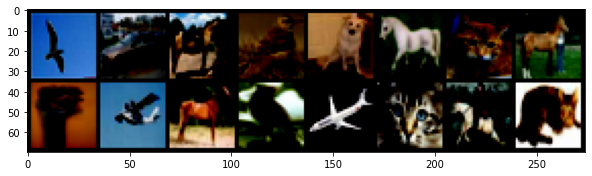

Shape of item: torch.Size([16, 3, 32, 32])


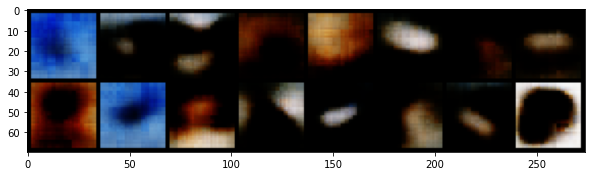

In [79]:


with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [80]:


model78 = CNNAutoEncoder().to(device)
optimizer78 = torch.optim.Adam(model78.parameters(), lr=1e-3, weight_decay=1e-5)

In [81]:
num_epochs = 5
outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
        img = img.to(device)
        recon = model78(img)
        loss = criterion(recon, img)
        
        optimizer78.zero_grad()
        loss.backward()
        optimizer78.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.1316
Epoch:2, Loss:0.1746
Epoch:3, Loss:0.1553
Epoch:4, Loss:0.1676
Epoch:5, Loss:0.1684


Shape of item: torch.Size([16, 3, 32, 32])


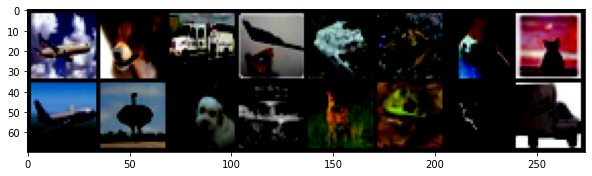

Shape of item: torch.Size([16, 3, 32, 32])


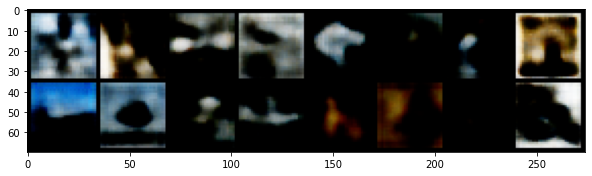

In [82]:

with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [83]:


model5 = CNNAutoEncoder100().to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=1e-3, weight_decay=1e-5)

In [84]:

NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model5(images)
        loss = criterion(reconstructions, images)
        
        optimizer5.zero_grad()
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 29.4731, Loss: 0.1993
Epoch: 2, Time: 29.0309, Loss: 0.1592
Epoch: 3, Time: 30.1115, Loss: 0.1556
Epoch: 4, Time: 29.3143, Loss: 0.1536
Epoch: 5, Time: 29.1267, Loss: 0.1527


Shape of item: torch.Size([16, 3, 32, 32])


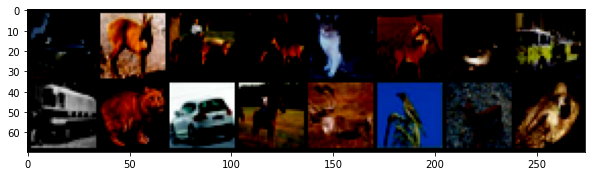

Shape of item: torch.Size([16, 3, 32, 32])


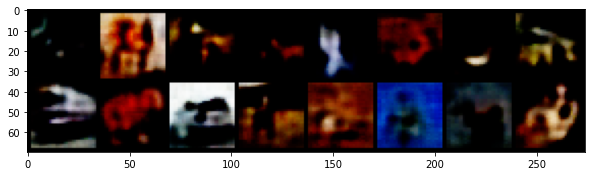

In [85]:


with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [86]:


model6 = CNNAutoEncoder1000().to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=1e-3, weight_decay=1e-5)

In [87]:


NUM_EPOCHS = 2
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model6(images)
        loss = criterion(reconstructions, images)
        
        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 621.1678, Loss: 0.2109
Epoch: 2, Time: 607.5042, Loss: 0.1601


Shape of item: torch.Size([16, 3, 32, 32])


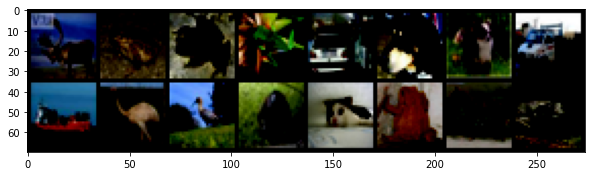

Shape of item: torch.Size([16, 3, 32, 32])


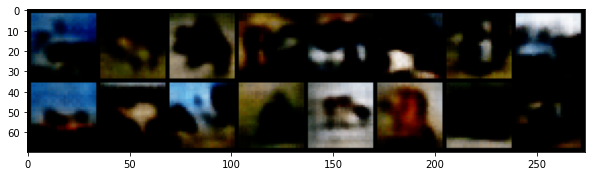

In [88]:

with torch.no_grad():
    imgs = outputs[1][1].detach().cpu()
    recon = outputs[1][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [89]:

import time
#For 10 Layers
class CNNAutoEncoderLayer10(nn.Module):
    # code
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(6, 9, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(9, 12, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(12, 15, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(15, 18, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(18, 21, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(21, 24, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 27, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(27, 30, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(30, 32, 3, stride=1),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 12, 12)),
            nn.ConvTranspose2d(32, 30, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(30, 27, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(27, 24, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 21, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(21, 18, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(18, 15, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 12, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 9, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 6, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 3, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class CNNAutoEncoderLayer5(nn.Module):
    # code
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(6, 9, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(9, 12, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(12, 15, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(15, 18, 3, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(18, 15, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 12, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 9, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 6, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 3, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class CNNAutoEncoderLayer1(nn.Module):
    # code
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(6, 3, 3, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
class CNNAutoEncoderLayer3(nn.Module):
    # code
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(6, 9, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(9, 12, 3, stride=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 9, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 6, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 3, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded





In [90]:

model7 = CNNAutoEncoderLayer10().to(device)
optimizer7 = torch.optim.Adam(model7.parameters(), lr=1e-3, weight_decay=1e-5)

In [91]:


NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model7(images)
        loss = criterion(reconstructions, images)
        
        optimizer7.zero_grad()
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 53.3689, Loss: 0.2001
Epoch: 2, Time: 52.6713, Loss: 0.1699
Epoch: 3, Time: 52.7437, Loss: 0.1658
Epoch: 4, Time: 53.6449, Loss: 0.1640
Epoch: 5, Time: 52.7846, Loss: 0.1629


Shape of item: torch.Size([16, 3, 32, 32])


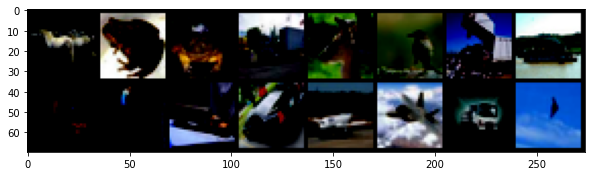

Shape of item: torch.Size([16, 3, 32, 32])


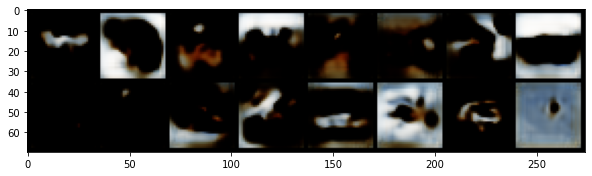

In [92]:


with torch.no_grad():
    imgs = outputs[3][1].detach().cpu()
    recon = outputs[3][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [93]:


model8 = CNNAutoEncoderLayer5().to(device)
optimizer8 = torch.optim.Adam(model8.parameters(), lr=1e-3, weight_decay=1e-5)

In [94]:


NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model8(images)
        loss = criterion(reconstructions, images)
        
        optimizer8.zero_grad()
        loss.backward()
        optimizer8.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 35.7834, Loss: 0.1712
Epoch: 2, Time: 35.4400, Loss: 0.1517
Epoch: 3, Time: 34.8841, Loss: 0.1486
Epoch: 4, Time: 35.1626, Loss: 0.1474
Epoch: 5, Time: 37.0074, Loss: 0.1468


Shape of item: torch.Size([16, 3, 32, 32])


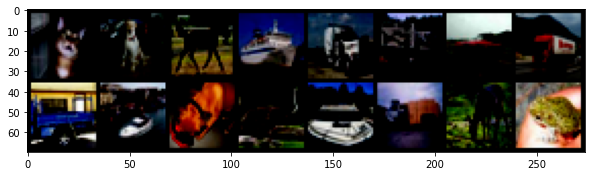

Shape of item: torch.Size([16, 3, 32, 32])


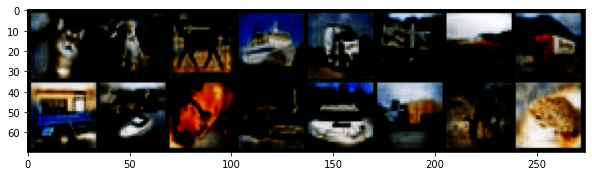

In [95]:


with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [96]:

model10 = CNNAutoEncoderLayer3().to(device)
optimizer10 = torch.optim.Adam(model10.parameters(), lr=1e-3, weight_decay=1e-5)

In [97]:

NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model10(images)
        loss = criterion(reconstructions, images)
        
        optimizer10.zero_grad()
        loss.backward()
        optimizer10.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 28.8093, Loss: 0.1643
Epoch: 2, Time: 28.7610, Loss: 0.1480
Epoch: 3, Time: 27.8770, Loss: 0.1463
Epoch: 4, Time: 28.0675, Loss: 0.1456
Epoch: 5, Time: 28.0369, Loss: 0.1453


Shape of item: torch.Size([16, 3, 32, 32])


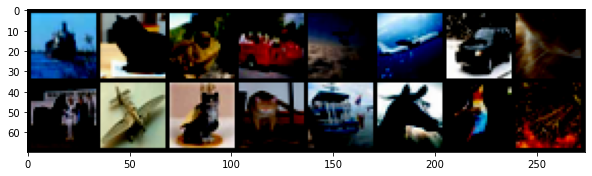

Shape of item: torch.Size([16, 3, 32, 32])


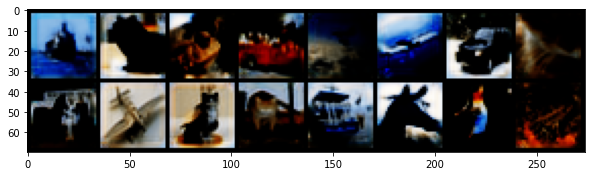

In [98]:

with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

In [99]:


model9 = CNNAutoEncoderLayer1().to(device)
optimizer9 = torch.optim.Adam(model9.parameters(), lr=1e-3, weight_decay=1e-5)

In [100]:


NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = model9(images)
        loss = criterion(reconstructions, images)
        
        optimizer9.zero_grad()
        loss.backward()
        optimizer9.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 20.7734, Loss: 0.1632
Epoch: 2, Time: 21.5476, Loss: 0.1481
Epoch: 3, Time: 21.3728, Loss: 0.1477
Epoch: 4, Time: 20.6403, Loss: 0.1475
Epoch: 5, Time: 21.3862, Loss: 0.1474


Shape of item: torch.Size([16, 3, 32, 32])


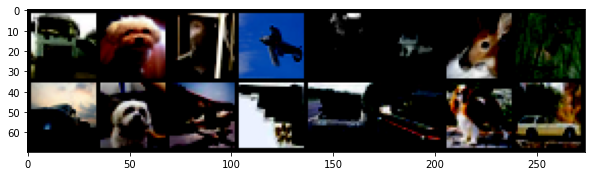

Shape of item: torch.Size([16, 3, 32, 32])


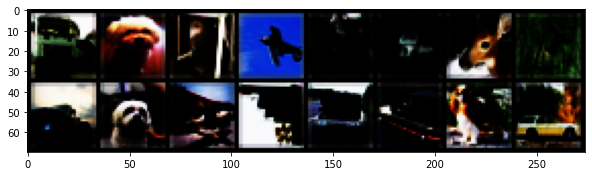

In [101]:
with torch.no_grad():
    imgs = outputs[4][1].detach().cpu()
    recon = outputs[4][2].detach().cpu()

item = imgs
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

item = recon
print(f"Shape of item: {item.shape}")
imshow(torchvision.utils.make_grid(item))

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

Autoencoder is an unsupervised learning algorithm that learns the compressed representation of input data. The main goal of an autoencoder is to reduce the input data's dimensionality while preserving as much relevant information as possible. It is composed of two parts: the encoder and the decoder. The encoder takes the input data and compresses it into a lower-dimensional representation, while the decoder takes this lower-dimensional representation and reconstructs the original input data.

Autoencoders are different from other data-representation methods like PCA, t-SNE, and Variational Autoencoders (VAEs) in several ways.

Firstly, PCA and t-SNE are linear and non-linear dimensionality reduction techniques, respectively. PCA finds the directions of maximal variance in the data, while t-SNE maps the high-dimensional data into a low-dimensional space while preserving the pairwise distances between the data points. In contrast, autoencoders can learn complex, non-linear transformations from the input data to the encoded representation, allowing for more expressive data representations.

Secondly, VAEs are another type of autoencoder that adds a probabilistic element to the encoding process. VAEs model the distribution of the encoded representation and allow for sampling of new data points from this distribution. This allows VAEs to generate new data points that are similar to the input data but not present in the original dataset. Autoencoders, on the other hand, do not explicitly model the distribution of the encoded representation, and are primarily used for data compression and reconstruction.

Lastly, autoencoders can be used for various applications, such as image and text generation, anomaly detection, and transfer learning. In contrast, PCA and t-SNE are mainly used for data visualization and exploratory data analysis.

Overall, autoencoders are powerful data representation methods that can learn complex non-linear transformations from the input data to a lower-dimensional representation, allowing for more expressive data representations and a range of applications beyond data visualization.

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [102]:
class CNNAutoEncoder102(nn.Module):
    def __init__(self):
        super().__init__()  
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=14, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=14, out_channels=12, kernel_size=6, stride=2),
            nn.ReLU(), 
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=6),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 1, 1)),
            nn.ConvTranspose2d(in_channels=10, out_channels=12, kernel_size=6),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=14, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=14, out_channels=3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def enc(self, x):
        return self.encoder(x)




In [103]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transformations to be applied to the CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the CIFAR-10 train dataset with 1000 samples per class
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the train dataset to contain only 1000 samples per class
class_counts = [0] * 10
train_indices = []
y_train = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if class_counts[label] < 1000:
        y_train.append(label)
        train_indices.append(i)
        class_counts[label] += 1
    if all(count == 1000 for count in class_counts):
        break
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

# Define the CIFAR-10 test dataset with 100 samples per class
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter the test dataset to contain only 100 samples per class
class_counts = [0] * 10
test_indices = []
y_test = []
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if class_counts[label] < 100:
        y_test.append(label)
        test_indices.append(i)
        class_counts[label] += 1
    if all(count == 100 for count in class_counts):
        break
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Define the train and test dataloaders with batch size 1 (since we will encode each image individually)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [104]:
modelf = CNNAutoEncoder102().to(device)
optimizerf = torch.optim.Adam(modelf.parameters(),lr=1e-3,weight_decay=1e-5)
                             

In [105]:
NUM_EPOCHS = 5
outputs = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    epoch_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)
        reconstructions = modelf(images)
        loss = criterion(reconstructions, images)
        
        optimizerf.zero_grad()
        loss.backward()
        optimizerf.step()
        
        epoch_loss += loss.item() * images.size(0)
    
    end_time = time.time()
    epoch_loss /= len(train_loader.dataset)
    
    print(f"Epoch: {epoch+1}, Time: {end_time - start_time:.4f}, Loss: {epoch_loss:.4f}")
    outputs.append((epoch, images, reconstructions))

Epoch: 1, Time: 43.4336, Loss: 0.1974
Epoch: 2, Time: 43.4736, Loss: 0.1840
Epoch: 3, Time: 43.3273, Loss: 0.1823
Epoch: 4, Time: 43.6173, Loss: 0.1807
Epoch: 5, Time: 43.9383, Loss: 0.1802


In [106]:
from sklearn.neighbors import KNeighborsClassifier

# Use the encoder model to transform the images in the train and test sets into encoded representations
def encode_data(model, data_loader):
    encoded_data = []
    for img, _ in data_loader:
        img = img.to(device)
        recon = model.enc(img)
        recon = recon.detach().cpu().numpy()
        encoded_data.append(recon)
    return encoded_data


In [107]:
x_train_encoded = encode_data(modelf, train_loader)
x_test_encoded = encode_data(modelf, test_loader)

In [108]:
x_train=np.array(x_train_encoded)
print(x_train.shape)
x_train=x_train.reshape(10000,10)
print(x_train.shape)

(10000, 1, 10)
(10000, 10)


In [109]:
x_test=np.array(x_test_encoded)
print(x_test.shape)
x_test=x_test.reshape(1000,10)
print(x_test.shape)

(1000, 1, 10)
(1000, 10)


In [110]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(x_train, y_train)

y_pred = knn_classifier.predict(x_test)
accuracy = knn_classifier.score(x_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.27
              precision    recall  f1-score   support

           0       0.27      0.41      0.32       100
           1       0.25      0.24      0.25       100
           2       0.22      0.33      0.26       100
           3       0.23      0.20      0.21       100
           4       0.22      0.24      0.23       100
           5       0.30      0.20      0.24       100
           6       0.28      0.30      0.29       100
           7       0.25      0.18      0.21       100
           8       0.38      0.39      0.39       100
           9       0.34      0.20      0.25       100

    accuracy                           0.27      1000
   macro avg       0.27      0.27      0.27      1000
weighted avg       0.27      0.27      0.27      1000



## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [111]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [112]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [113]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [114]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."